In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from ROOT import TH1F, TCanvas, RDataFrame
%matplotlib inline

Welcome to JupyROOT 6.18/04


In [2]:
def smooth(x, window_len=11, window="hanning"):
    # if x.ndim != 1:
    #     raise ValueError("smooth only accepts 1 dimension arrays.")

    # if x.size < window_len:
    #     raise ValueError("Input vector needs to be bigger than window size.")

    # if window_len < 3:
    #     return x

    if not window in ["flat", "hanning", "hamming", "bartlett", "blackman"]:
        raise ValueError(
            "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        )

    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-2 : -window_len - 1 : -1]]
    # print(len(s))
    if window == "flat":  # moving average
        w = np.ones(window_len)
    else:
        w = eval("np." + window + "(window_len)")

    y = signal.convolve(s, w / w.sum(), mode="same")

    return y

In [3]:
rel_path = "./Labs/muon_decay/"
filename = rel_path + "oscil_191216.root"

In [4]:
df = RDataFrame("t1",filename)

In [7]:
df_np = df.AsNumpy()


In [8]:
df_np["channel1"].size

9032

In [10]:
raw_data = df_np["channel1"][368]
n_per_event = raw_data.size()
timesteps = np.arange(0,n_per_event,1)
raw_data *= -1.0
smoothed_data = smooth(raw_data, window_len=51, window='bartlett')
data = np.concatenate((smoothed_data[:n_per_event ,np.newaxis], timesteps[:,np.newaxis]), axis=1)
peaks, properties = signal.find_peaks(data[: ,0], height=0.2 * data[: ,0].max())
results_w = signal.peak_widths(data[: ,0], peaks, rel_height=0.95)


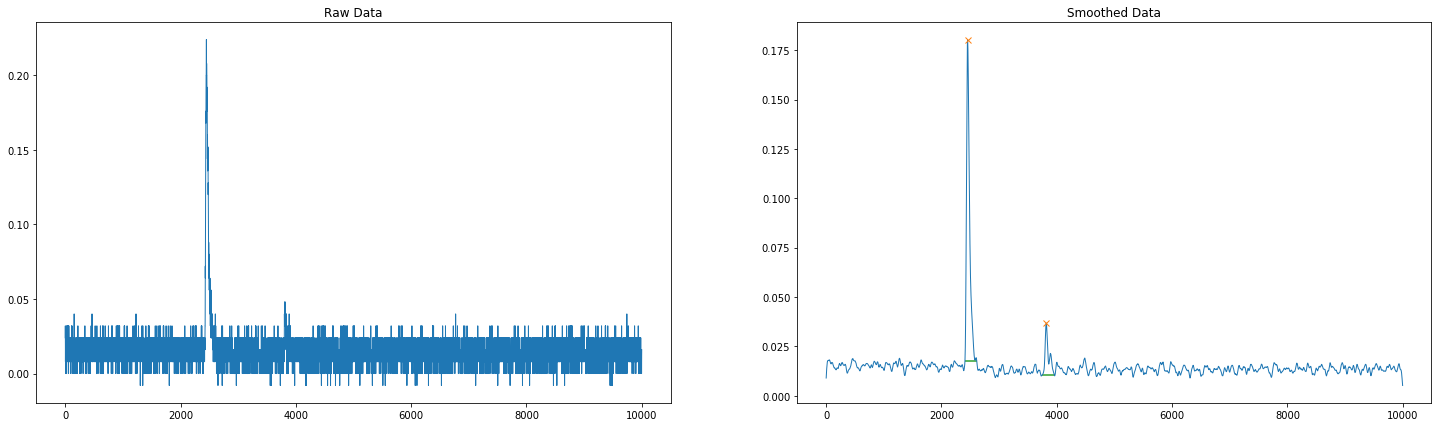

In [11]:
plt.figure(figsize=(25,7))
plt.subplot(121)
plt.plot(timesteps, raw_data, '-', lw=1)
plt.title("Raw Data")
plt.subplot(122)
plt.plot(data[:,1], data[:,0],'-', lw=1)
plt.plot(peaks, data[:,0][peaks], "x")
plt.hlines(*results_w[1:], color="C2")
plt.title("Smoothed Data")
plt.show()

In [12]:
print(f'Peaks width: {results_w[0]}')
for i in range(results_w[1:][0].size):
    print(f'Found peak in range: {results_w[2][i]}, {results_w[3][i]}')
print(f"Found peaks at indices {peaks} with amplitude: {data[peaks,0]}")

Peaks width: [205.34625132 209.95328245]
Found peak in range: 2407.096608920295, 2612.4428602396047
Found peak in range: 3745.2667050771124, 3955.219987528975
Found peaks at indices [2453 3817] with amplitude: [0.1803648 0.036736 ]


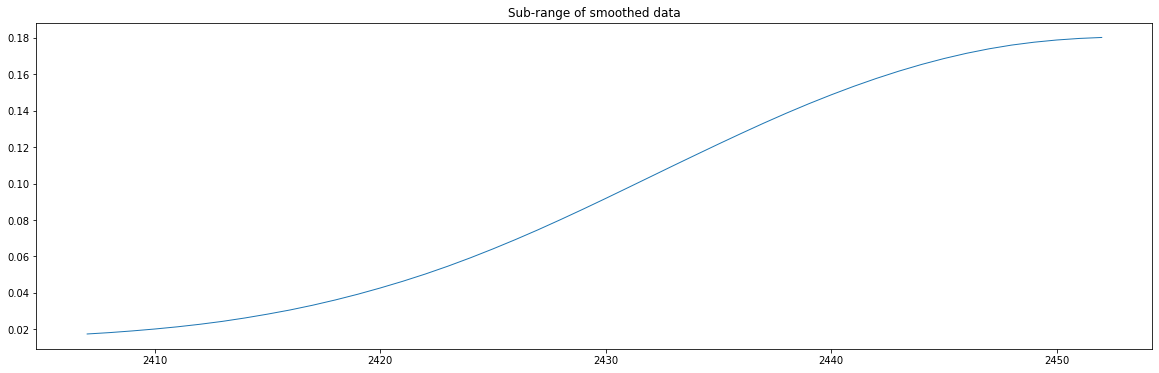

In [13]:
a = int(min(results_w[2]))
ranged_sm_data = data[a:peaks[0]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,1], ranged_sm_data[:,0],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

3745 3817


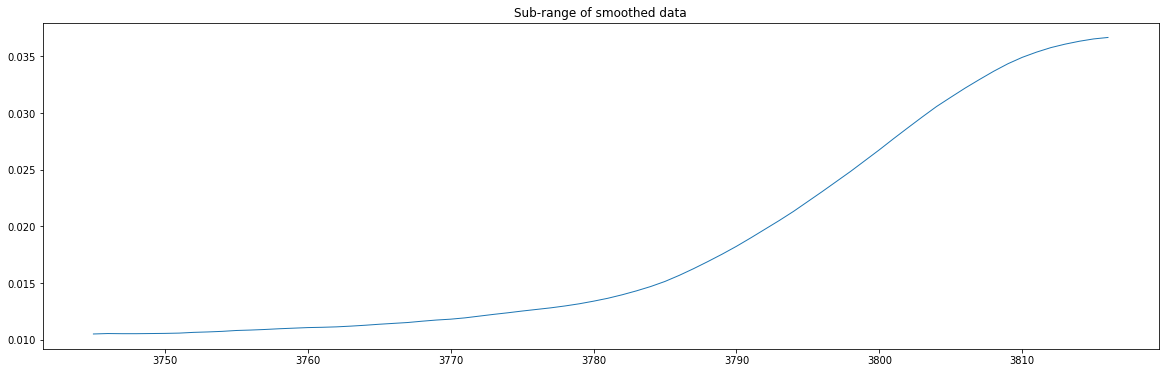

In [25]:
b = int((results_w[2][1]))
print(b,peaks[1])
ranged_sm_data = data[b:peaks[1]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,1], ranged_sm_data[:,0],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

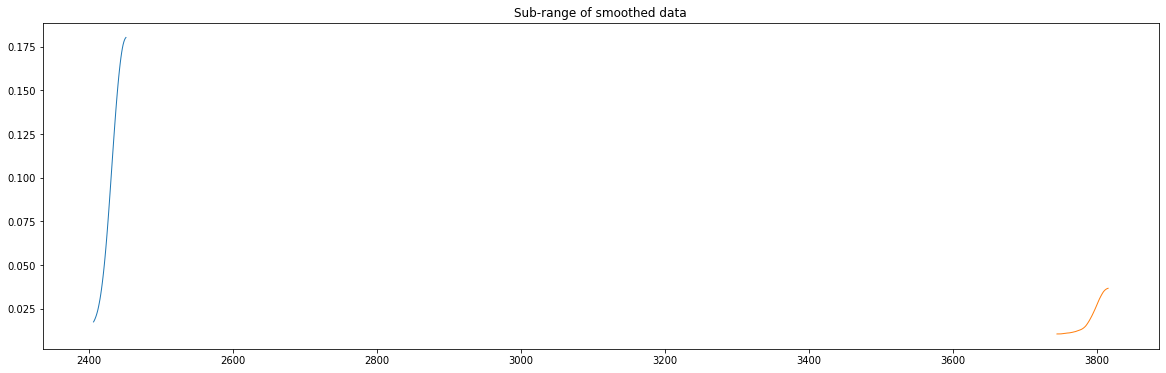

In [41]:
plt.figure(figsize=(20,6))
for min_t, peak in zip(results_w[2], peaks):
    min_t = int(min_t)
    ranged_sm_data = data[min_t:peak]
    plt.plot(ranged_sm_data[:,1], ranged_sm_data[:,0],'-', lw=1)
    plt.title("Sub-range of smoothed data")
plt.show()

In [26]:
import iminuit
import probfit

In [27]:
# We want to speed things up with Cython
%load_ext Cython

In [28]:
%%cython
cimport cython
from libc.math cimport exp
@cython.binding(True) # IMPORTANT: this tells Cython to dump the function signature
def sigmoid(double x, double p0, double p1, double p2, double p3):
    return p0 / (1.0 + exp(-1.0 * p2 * (x - p1) ) ) + p3


# def sigmoid(x, p0, p1, p2, p3):
#     return p0 / (1.0 + np.exp(-1.0 * p2 * (x - p1))) + p3


In [29]:
iminuit.describe(sigmoid)

['x', 'p0', 'p1', 'p2', 'p3']

In [30]:
# from scipy.interpolate import interp1d
# f1 = interp1d(
#                 data[a : peaks[0] + 1, 1],
#                 data[a : peaks[0] + 1, 0],
#             )
# xx = np.linspace(data[a, 1], data[peaks[0], 1], num=200)
# chi2_fit = probfit.Chi2Regression(sigmoid, xx, f1(xx))

In [31]:
chi2_fit = probfit.Chi2Regression(sigmoid, 
            timesteps[a : peaks[0]],
            smoothed_data[a : peaks[0]]
            )
# chi2_fit = probfit.Chi2Regression(
#     sigmoid,
#     data[a : peaks[0], 1],
#     data[a : peaks[0], 0],
# )

minuit = iminuit.Minuit(
                chi2_fit,
                p0=np.max(data[a : peaks[0] + 1, 0]),
                p1=peaks[0],
                p3=np.min(data[a : peaks[0] + 1, 0]),
                limit_p3=(0.001, 1.0),
                pedantic=False,
                print_level=1,
            )
minuit.migrad()
try:
    minuit.hesse()
except Exception as e:
    print(str(e))

------------------------------------------------------------------
| FCN = 0.0002305               |    Ncalls=1006 (1006 total)    |
| EDM = 6.2E-05 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

In [32]:
iminuit.describe(chi2_fit)

['p0', 'p1', 'p2', 'p3']

In [33]:
minuit.migrad()

------------------------------------------------------------------
| FCN = 0.0002155               |     Ncalls=52 (1080 total)     |
| EDM = 2.55E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


------------------------------------------------------------------
| FCN = 0.0002155               |     Ncalls=52 (1080 total)     |
| EDM = 2.55E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |   0.21    |   0.30    |            |            |         |         |       |
| 1 | p1   |  2432.2   |    2.0    |            |            |         |         |       |
| 2 | p2   |   0.11    |   0.47    |            |            |         |         |       |
| 3 | p3   |   0.001   |   0.853   |            |            |  0.001  |    1    |       |
------------------------------------------------------------------------------------------

In [34]:
minuit.hesse()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |   0.21    |   0.30    |            |            |         |         |       |
| 1 | p1   |  2432.2   |    2.0    |            |            |         |         |       |
| 2 | p2   |   0.11    |   0.47    |            |            |         |         |       |
| 3 | p3   |   0.001   |   0.853   |            |            |  0.001  |    1    |       |
------------------------------------------------------------------------------------------
------------------------------------
|    |     p0     p1     p2     p3 |
------------------------------------
| p0 |  1.000  0.051 -0.402 -0.045 |
| p1 |  0.051  1.000 -0.023  0.000 |
| p2 | -0.402 -0.023  1.000  0.023 |
| p3 | -0.045  0.000  0.023  1.000 |
-------------

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |   0.21    |   0.30    |            |            |         |         |       |
| 1 | p1   |  2432.2   |    2.0    |            |            |         |         |       |
| 2 | p2   |   0.11    |   0.47    |            |            |         |         |       |
| 3 | p3   |   0.001   |   0.853   |            |            |  0.001  |    1    |       |
------------------------------------------------------------------------------------------

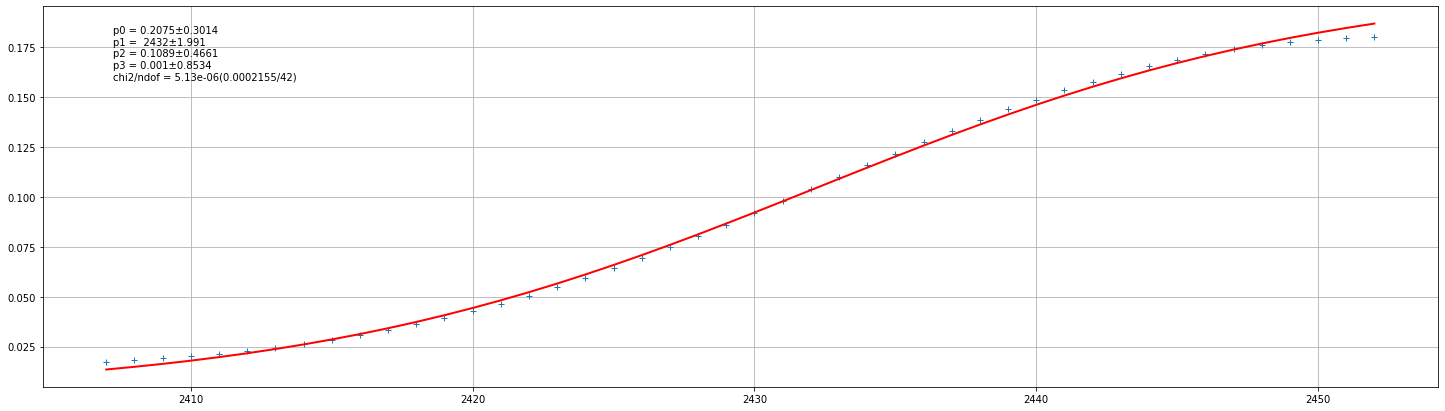

In [35]:
plt.figure(figsize=(25, 7))
chi2_fit.draw(minuit)
plt.show()

In [36]:
minuit.print_fmin()
minuit.print_matrix()

------------------------------------------------------------------
| FCN = 0.0002155               |     Ncalls=52 (1120 total)     |
| EDM = 2.55E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------
|    |     p0     p1     p2     p3 |
------------------------------------
| p0 |  1.000  0.051 -0.402 -0.045 |
| p1 |  0.051  1.000 -0.023  0.000 |
| p2 | -0.4

In [37]:
print(minuit.values)
print(minuit.errors)

<ValueView of Minuit at 560939b321a0>
  p0: 0.20746204052469255
  p1: 2432.2372338226155
  p2: 0.1088869465639426
  p3: 0.0010002238480999227
<ErrorView of Minuit at 560939b321a0>
  p0: 0.3013865456545574
  p1: 1.9908567627844949
  p2: 0.4661325657449136
  p3: 0.8534301390547996


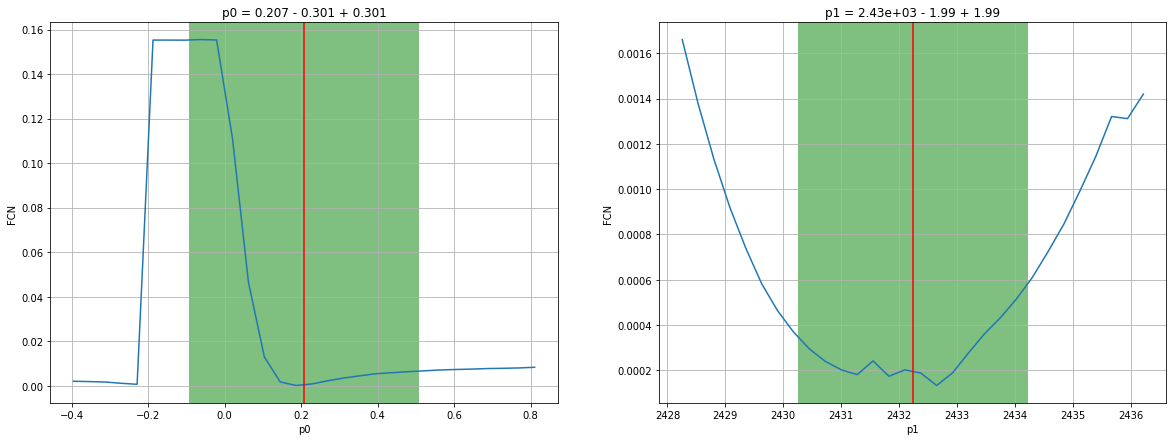

In [38]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p0')
plt.subplot(122)
minuit.draw_mnprofile('p1')
plt.show()

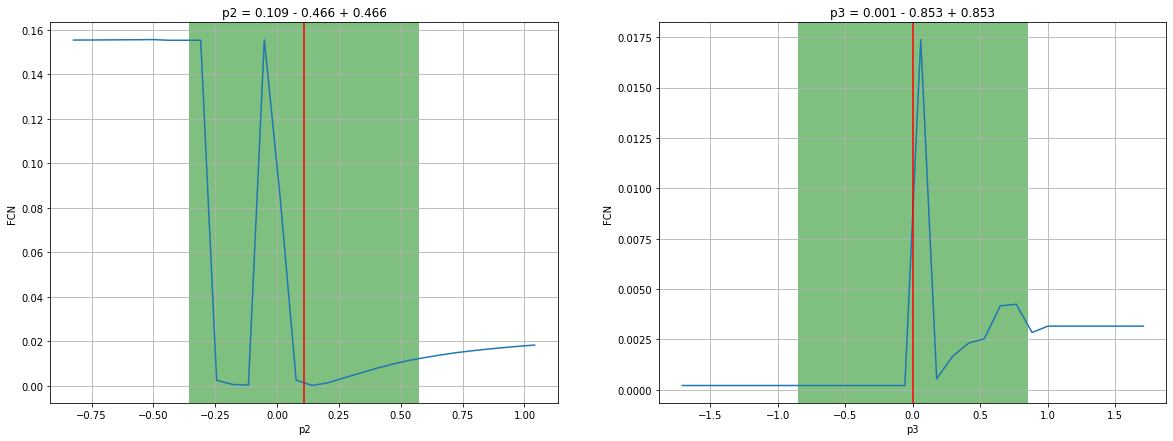

In [39]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p2')
plt.subplot(122)
minuit.draw_mnprofile('p3')
plt.show()